In [1]:
# ==============================================================
# CNN-LSTM GRID SEARCH & TEST FOR MOTION CLASSIFICATION
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
FEATURE_COLUMNS = ['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']
AUGMENTATION_MULTIPLIER = 3
EPOCHS = 100
BATCH_SIZE = 32

In [3]:
# ---------------------------------------------------------------
# FUNCTIONS
# ---------------------------------------------------------------
def augment_data(X_batch, jitter_strength=0.02, scale_strength=0.15, warp_strength=0.1):
    X_augmented = np.copy(X_batch)
    X_augmented += np.random.normal(0, jitter_strength, X_augmented.shape)
    scale_factor = np.random.uniform(1 - scale_strength, 1 + scale_strength,
                                     size=(X_augmented.shape[0], 1, X_augmented.shape[2]))
    X_augmented *= scale_factor
    for i in range(X_augmented.shape[0]):
        t = np.linspace(0, 1, X_augmented.shape[1])
        warp_noise = np.random.normal(0, warp_strength, X_augmented.shape[1])
        warp_path = np.cumsum(warp_noise)
        warp_path = (warp_path - warp_path.min()) / (warp_path.max() - warp_path.min() + 1e-8)
        warped_t = warp_path * (X_augmented.shape[1] - 1)
        for f in range(X_augmented.shape[2]):
            X_augmented[i,:,f] = np.interp(np.arange(X_augmented.shape[1]), warped_t, X_augmented[i,:,f])
        magnitude_noise = np.random.normal(0, warp_strength, X_augmented.shape[1])
        magnitude_warp = np.cumsum(magnitude_noise)
        magnitude_warp = (magnitude_warp - magnitude_warp.min()) / (magnitude_warp.max() - magnitude_warp.min() + 1e-8)
        magnitude_warp = 1 + (magnitude_warp * 2 - 1) * scale_strength
        for f in range(X_augmented.shape[2]):
            X_augmented[i,:,f] *= magnitude_warp
    return X_augmented

def create_windows(X, y, window_size, stride):
    Xs, ys = [], []
    for i in range(0, len(X) - window_size + 1, stride):
        window = X[i:i+window_size]
        label = np.bincount(y[i:i+window_size]).argmax()
        Xs.append(window)
        ys.append(label)
    return np.array(Xs), np.array(ys)

def build_model(input_shape, num_classes, dropout_rate, l2_reg):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(128, 7, activation='relu', kernel_regularizer=l2(l2_reg), padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Conv1D(64, 5, activation='relu', kernel_regularizer=l2(l2_reg), padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Conv1D(32, 3, activation='relu', kernel_regularizer=l2(l2_reg), padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        LSTM(64, kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
# ---------------------------------------------------------------
# LOAD & PREPROCESS
# ---------------------------------------------------------------
print("="*60)
print("LOADING TRAINING DATA & PREPROCESSING")
df_train = pd.read_csv("master_train.csv")
X_raw = df_train[FEATURE_COLUMNS].values
y_raw = df_train['Label'].values
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
num_classes = len(le.classes_)
print(f"Classes: {le.classes_}")
# ---------------------------------------------------------------
# GRID SEARCH
# ---------------------------------------------------------------
param_grid = [
    {'WINDOW_SIZE':32, 'STRIDE':8, 'LEARNING_RATE':0.0001, 'DROPOUT_RATE':0.3, 'L2_REG':0.001},
    {'WINDOW_SIZE':36, 'STRIDE':10, 'LEARNING_RATE':0.0001, 'DROPOUT_RATE':0.3, 'L2_REG':0.001},
    {'WINDOW_SIZE':48, 'STRIDE':12, 'LEARNING_RATE':0.0005, 'DROPOUT_RATE':0.4, 'L2_REG':0.001},
    {'WINDOW_SIZE':60, 'STRIDE':15, 'LEARNING_RATE':0.001, 'DROPOUT_RATE':0.5, 'L2_REG':0.0005},
    {'WINDOW_SIZE':40, 'STRIDE':10, 'LEARNING_RATE':0.0003, 'DROPOUT_RATE':0.3, 'L2_REG':0.001}
]

best_accuracy = 0
best_config = None
best_model = None

print("="*60)
print("STARTING GRID SEARCH")
for config in param_grid:
    print(f"\nTrying config: {config}")
    X_win, y_win = create_windows(X_scaled, y_enc, config['WINDOW_SIZE'], config['STRIDE'])
    X_train, X_val, y_train, y_val = train_test_split(X_win, y_win, test_size=0.2, stratify=y_win, random_state=42)

    X_aug, y_aug = [], []
    swallow_idx = le.transform(['Swallow'])[0]

    for i in range(X_train.shape[0]):
        X_aug.append(X_train[i])
        y_aug.append(y_train[i])
        extra_aug = AUGMENTATION_MULTIPLIER + 2 if y_train[i] == swallow_idx else AUGMENTATION_MULTIPLIER - 1
        for _ in range(extra_aug):
            X_aug.append(augment_data(X_train[i][np.newaxis,:,:])[0])
            y_aug.append(y_train[i])

    X_aug, y_aug = np.array(X_aug), np.array(y_aug)

    y_train_cat = to_categorical(y_aug, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
    ]

    model = build_model((config['WINDOW_SIZE'], X_train.shape[2]), num_classes,
                        config['DROPOUT_RATE'], config['L2_REG'])
    model.compile(optimizer=Adam(learning_rate=config['LEARNING_RATE']),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_aug, y_train_cat, validation_data=(X_val, y_val_cat),
              epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)

    preds = np.argmax(model.predict(X_val), axis=1)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy: {acc*100:.2f}%")
    if acc > best_accuracy:
        best_accuracy = acc
        best_config = config
        best_model = model

print("\n" + "="*60)
print("BEST CONFIGURATION")
print(f"Config: {best_config}")
print(f"Best Validation Accuracy: {best_accuracy*100:.2f}%")
best_model.save("best_model_grid_search.h5")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

LOADING TRAINING DATA & PREPROCESSING
Classes: ['Chew' 'HeadNodding' 'Swallow' 'Yawn']
STARTING GRID SEARCH

Trying config: {'WINDOW_SIZE': 32, 'STRIDE': 8, 'LEARNING_RATE': 0.0001, 'DROPOUT_RATE': 0.3, 'L2_REG': 0.001}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Validation Accuracy: 97.90%

Trying config: {'WINDOW_SIZE': 36, 'STRIDE': 10, 'LEARNING_RATE': 0.0001, 'DROPOUT_RATE': 0.3, 'L2_REG': 0.001}
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Validation Accuracy: 100.00%

Trying config: {'WINDOW_SIZE': 48, 'STRIDE': 12, 'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'L2_REG': 0.001}


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
Validation Accuracy: 98.95%

Trying config: {'WINDOW_SIZE': 60, 'STRIDE': 15, 'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.5, 'L2_REG': 0.0005}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
Validation Accuracy: 100.00%

Trying config: {'WINDOW_SIZE': 40, 'STRIDE': 10, 'LEARNING_RATE': 0.0003, 'DROPOUT_RATE': 0.3, 'L2_REG': 0.001}
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Validation Accuracy: 99.12%

BEST CONFIGURATION
Config: {'WINDOW_SIZE': 36, 'STRIDE': 10, 'LEARNING_RATE': 0.0001, 'DROPOUT_RATE': 0.3, 'L2_REG': 0.001}
Best Validation Accuracy: 100.00%


['scaler.pkl']


LOADING TEST DATA & EVALUATING BEST MODEL
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Test Accuracy: 96.65%
              precision    recall  f1-score   support

        Chew       1.00      0.99      1.00       142
 HeadNodding       1.00      0.99      0.99       143
     Swallow       0.99      0.89      0.94       141
        Yawn       0.89      1.00      0.94       142

    accuracy                           0.97       568
   macro avg       0.97      0.97      0.97       568
weighted avg       0.97      0.97      0.97       568



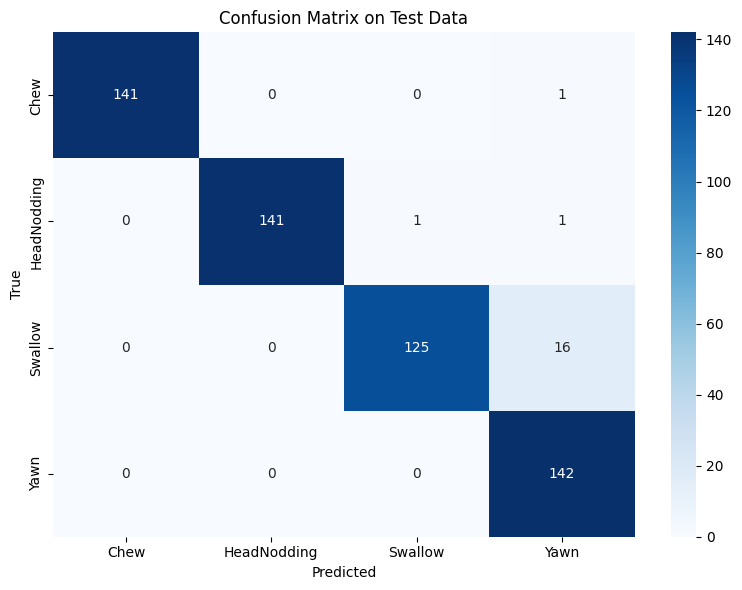

In [5]:
# ---------------------------------------------------------------
# TESTING ON FINAL TEST DATA
# ---------------------------------------------------------------
print("\n" + "="*60)
print("LOADING TEST DATA & EVALUATING BEST MODEL")
df_test = pd.read_csv("master_test.csv")
X_test_raw = df_test[FEATURE_COLUMNS].values
y_test_raw = df_test['Label'].values
y_test_enc = le.transform(y_test_raw)
X_test_scaled = scaler.transform(X_test_raw)
X_test_win, y_test_win = create_windows(X_test_scaled, y_test_enc,
                                        best_config['WINDOW_SIZE'], best_config['STRIDE'])

preds = np.argmax(best_model.predict(X_test_win), axis=1)
acc = accuracy_score(y_test_win, preds)
print(f"\nTest Accuracy: {acc*100:.2f}%")
print(classification_report(y_test_win, preds, target_names=le.classes_))

cm = confusion_matrix(y_test_win, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()